In [1]:
folder = "experiments/train_1000/curves/"

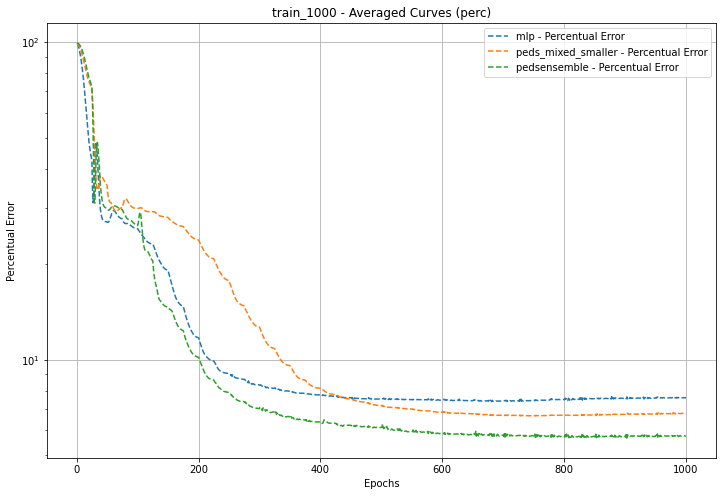

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt

def plot_losses(models_data, experiment_name, plot_mode="both"):
    """
    plot_mode: 'val' for validation loss, 'perc' for percentual error, 'both' for both
    """
    plt.figure(figsize=(12, 8))

    for model_data in models_data:
        train_losses = model_data['train_losses']
        val_losses = np.sqrt(model_data['val_losses'])
        epochs = model_data['epochs']
        model_name = model_data['model_name']
        valid_variance = model_data['valid_variance']
        valid_perc_losses = model_data['valid_perc_losses']

        if plot_mode in ["val", "both"]:
            plt.plot(range(1, epochs + 1), val_losses, label=f'{model_name} - Validation Loss')
            if "ensemble" in model_name:
                std_dev = np.sqrt(valid_variance)
                #plt.fill_between(range(1, epochs + 1), val_losses - std_dev, val_losses + std_dev, alpha=0.2, color='blue')

        if plot_mode in ["perc", "both"]:
            plt.plot(range(1, epochs + 1), valid_perc_losses, label=f'{model_name} - Percentual Error', linestyle='--')
            std_dev = np.sqrt(valid_variance)
            #plt.fill_between(range(1, epochs + 1), valid_perc_losses - std_dev, valid_perc_losses + std_dev, alpha=0.2, color='blue')

    plt.xlabel('Epochs')
    ylabel = {
        "val": "Validation Loss",
        "perc": "Percentual Error",
        "both": "Loss / Error"
    }[plot_mode]
    plt.ylabel(ylabel)
    plt.title(f'{experiment_name} - Averaged Curves ({plot_mode})')
    plt.legend(loc='best')
    plt.grid(True)

    # Set y-limits for better visibility if mode is 'perc'
    
    """all_perc = np.concatenate([model['valid_perc_losses'] for model in models_data])
    perc_min, perc_max = np.min(all_perc), np.max(all_perc)
    margin = 0.02 * (perc_max - perc_min)  # small margin
    plt.ylim(perc_min - margin, perc_max + margin)"""
    plt.yscale('log')


    plt.savefig(f'experiments/{experiment_name}/figures/training_curves_plot_{plot_mode}.png')

def average_metrics(metrics_list):
    stacked = np.stack(metrics_list, axis=0)
    return np.mean(stacked, axis=0)


folder = "experiments/train_1000/curves/"
experiment_name = "train_1000"
model_names = ["mlp", "peds_mixed_smaller", "pedsensemble"]
plot_mode = "perc"  # change to "val", "perc", or "both"

models_data = []

for model_name in model_names:
    
    train_losses_list = []
    val_losses_list = []
    variance_list = []
    perc_losses_list = []

    for filename in os.listdir(folder):
        if filename.endswith(".npz") and f"training_curves_{model_name}" in filename:
            curves = np.load(os.path.join(folder, filename), allow_pickle=True)
            train_losses_list.append(curves['epoch_losses'])
            val_losses_list.append(curves['valid_losses'])
            variance_list.append(curves['valid_variance'])
            perc_losses_list.append(curves['valid_perc_losses'])

    if train_losses_list:  # <- This line should be inside the outer loop
        model_data = {
            'train_losses': average_metrics(train_losses_list),
            'val_losses': average_metrics(val_losses_list),
            'valid_variance': average_metrics(variance_list),
            'valid_perc_losses': average_metrics(perc_losses_list),
            'epochs': len(train_losses_list[0]),
            'model_name': model_name
        }
        models_data.append(model_data)  # <- This too


plot_losses(models_data, experiment_name, plot_mode=plot_mode)


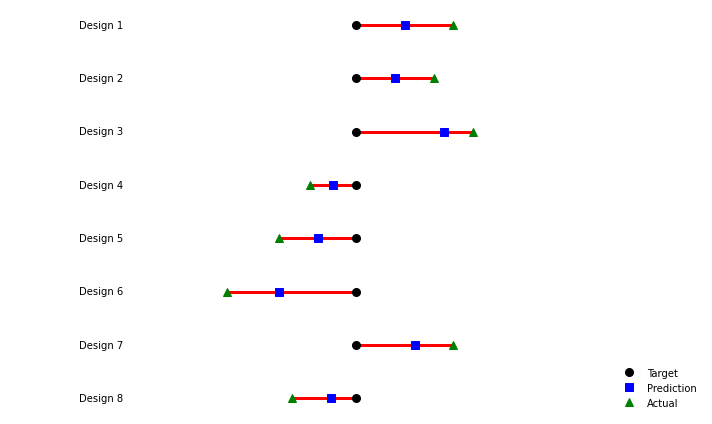

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example values – replace these with real data
kappa_targets = np.array([12, 15, 20, 25, 30, 45, 60, 90])
kappa_preds   = np.array([12.5, 15.5, 21.5, 24.5, 29, 42, 63, 88])
kappa_actuals = np.array([13, 16, 22, 24, 28, 40, 65, 85])
num_designs = len(kappa_targets)

# Calculate % distances (normalized visually)
def percent_offset(ref, val):
    return (val - ref) / ref * 100

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(num_designs):
    y = num_designs - i  # label position (Design 1 on top)

    # Percentual distances from center (target)
    x_target = 0
    x_pred = percent_offset(kappa_targets[i], kappa_preds[i])
    x_actual = percent_offset(kappa_targets[i], kappa_actuals[i])

    # Red line: design error
    ax.plot([x_target, x_actual], [y, y], color='red', linewidth=3)

    # Points
    ax.plot(x_target, y, 'o', color='black', markersize=8, label='Target' if i == 0 else "")
    ax.plot(x_pred, y, 's', color='blue', markersize=8, label='Prediction' if i == 0 else "")
    ax.plot(x_actual, y, '^', color='green', markersize=8, label='Actual' if i == 0 else "")

    # Label on the left
    ax.text(-20, y, f'Design {i+1}', va='center', ha='right', fontsize=10)

# Clean look
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)
ax.set_xlim(-30, 30)  # you can adjust this range based on your max % error
ax.legend(loc='lower right', frameon=False)
plt.tight_layout()
plt.show()
